# 1. Dataset Preprocessing

### Importing necessary libraries

In [376]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math



from numpy import array
from numpy import argmax
from numpy import mean
from numpy import std


import os
import os.path
import pickle


import sklearn 

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier


from sklearn.utils import class_weight


from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier 

from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import MinMaxScaler


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from scipy import stats

### Parameters

In [164]:
window_size = 23
resposible_residue = 'K'
directory = '/Users/smshovan/Google Drive/Colab Notebooks/New Research/Master\'s Thesis 2/'

### Reading data 

In [165]:
full_data = pd.read_table(directory+'Formylation.elm')
full_data.head()

,PLMD ID,Uniprot Accession,Position,Type,Sequence,Species,PMIDs
0,PLMD-2747,P00448,114,Formylation,MSYTLPSLPYAYDALEPHFDKQTMEIHHTKHHQTYVNNANAALESL...,Escherichia coli (strain K12),26840995
1,PLMD-2747,P00448,91,Formylation,MSYTLPSLPYAYDALEPHFDKQTMEIHHTKHHQTYVNNANAALESL...,Escherichia coli (strain K12),26840995
2,PLMD-2979,P02359,171,Formylation,MPRRRVIGQRKILPDPKFGSELLAKFVNILMVDGKKSTAESIVYSA...,Escherichia coli (strain K12),26840995
3,PLMD-2987,P02413,13,Formylation,MRLNTLSPAEGSKKAGKRLGRGIGSGLGKTGGRGHKGQKSRSGGGV...,Escherichia coli (strain K12),26840995
4,PLMD-2987,P02413,29,Formylation,MRLNTLSPAEGSKKAGKRLGRGIGSGLGKTGGRGHKGQKSRSGGGV...,Escherichia coli (strain K12),26840995


In [166]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   PLMD ID            188 non-null    object
 1   Uniprot Accession  188 non-null    object
 2   Position           188 non-null    int64 
 3   Type               188 non-null    object
 4   Sequence           188 non-null    object
 5   Species            188 non-null    object
 6   PMIDs              188 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 10.4+ KB


### Convert to fasta file for removing homologous sequences

In [167]:
f= open("sequence_tb.fasta","w+")
for index in range(full_data.shape[0]):
  f.write(">" + full_data['PLMD ID'][index]+ "\n"+ full_data['Sequence'][index]+"\n")
f.close()

### Reduce homologous sequence using CD-HIT
db is the filename of input, 
db90 is output, 
* -c 1.0, means 100% identity, is the clustering threshold
* -c 0.9, means 90% identity, is the clustering threshold
* -n 5 is the word size
* -d 0 use sequence name in fasta header till the first white space
* -M 16000, to use 16GB RAM
* -T 8, to use 8 threads

Choose of word size:

* -n 5 for thresholds 0.7 ~ 1.0
* -n 4 for thresholds 0.6 ~ 0.7
* -n 3 for thresholds 0.5 ~ 0.6
* -n 2 for thresholds 0.4 ~ 0.5

In [99]:
pwd

"/Users/smshovan/Google Drive/Colab Notebooks/New Research/Master's Thesis 2"

In [100]:
#install cd-hit in anaconda 
if not os.system('cd-hit -i sequence_tb.fasta -o reduced_sequence_tb.fasta -c .4 -n 2 '):
    print("Successful")

Successful


In [101]:
reduced_data = pd.read_table(directory+'reduced_sequence_tb.fasta')
reduced_data.shape

(185, 1)

### Read the non-redundent sequence padding with dummy residue 'X'

In [168]:
f= open("reduced_sequence_tb.fasta","r")


reduced_sequence_tb_ls = f.readlines()

f.close



<function TextIOWrapper.close()>

In [169]:
plmd_id = [None]* math.ceil(len(reduced_sequence_tb_ls)/2)
sequence = [None]*math.ceil(len(reduced_sequence_tb_ls)/2)

dummy= 'X'* math.floor(window_size/2)

row=0
for i in range(0,len(reduced_sequence_tb_ls),2):
  plmd_id[row] = reduced_sequence_tb_ls[i][1:-1]
  sequence[row] =  dummy+reduced_sequence_tb_ls[i+1][0:-1]+dummy
  row = row + 1

In [170]:
plmd_id_df = pd.DataFrame(plmd_id, columns = ['PLMD-ID'])
sequence_df = pd.DataFrame(sequence, columns = ['Sequence'])

reduced_sequence_tb_df = pd.concat([plmd_id_df, sequence_df], axis=1)

reduced_sequence_tb_df.shape[0]

93

# 2. Windowing the protein into peptides
### Split positives and negatives peptides from sequence

### Fetching positives

In [171]:
positives_ls =[]

for i in range ( reduced_sequence_tb_df.shape[0]):
    for j in range ( full_data.shape[0]):
        if (reduced_sequence_tb_df['PLMD-ID'][i] == full_data['PLMD ID'][j]  ):
            positives_ls.append(reduced_sequence_tb_df['Sequence'][i][full_data['Position'][j] - 1 : full_data['Position'][j] + 2*math.floor(window_size/2) ]) 



In [172]:
positives_ls = (np.unique(np.array(positives_ls))).tolist()
len(positives_ls)

182

### Fetching negatives

In [173]:
# 1. First fetch all peptides with the resposible residue in the middle

all_peptides_ls =[]

for i in range ( reduced_sequence_tb_df.shape[0]):
    for j in range ( len(reduced_sequence_tb_df['Sequence'][i])):
        if (reduced_sequence_tb_df['Sequence'][i][j] == resposible_residue):
            all_peptides_ls.append(reduced_sequence_tb_df['Sequence'][i][j - math.floor(window_size/2)  : j + math.floor(window_size/2) + 1 ]) 



In [174]:
len(all_peptides_ls)

1819

In [175]:
# 2. Now subtract positives from negatives
temp = all_peptides_ls[:]
count = 0
for i in range (len (all_peptides_ls) ):
    for j in range (len(positives_ls) ):
        if (all_peptides_ls[i] == positives_ls[j]):
            temp.pop(i - count)
            count = count + 1
            break
negatives_ls = temp

In [176]:
# 3. Remove the duplicates
negatives_ls =  (np.unique(np.array(negatives_ls))).tolist()

In [177]:
len(negatives_ls)

1636

In [178]:
np.array(negatives_ls)

array(['AAAAEVEERTRKLQQYREMLIAD', 'AADAAPAQAEEKKEAAPAAAPAA',
       'AADNGDAWVEVKGQKMAPPQISA', ..., 'YVDVGATYYFNKNMSTYVDYKIN',
       'YYLGNADEIAAKAAAVANQGKAK', 'YYTTGHYSIFIKVMCRSIDALQH'], dtype='<U23')

In [179]:
imbalance_ratio = len(negatives_ls) / len(positives_ls)
print(imbalance_ratio)

8.989010989010989


### Save positives and negatives into dataframe

In [180]:
positives_df = pd.DataFrame(positives_ls, columns =['positives'])
negatives_df = pd.DataFrame(negatives_ls, columns =['negatives'])

### (Optional Start) if you want to avoid padding 

In [181]:
idx_list_pos = []
for i in range(positives_df.shape[0]):
    if (positives_df['positives'][i][0] == 'X'  or positives_df['positives'][i][-1] == 'X' ):
        idx_list_pos.append(i)
positives_df = positives_df.drop(index = idx_list_pos)

In [182]:
positives_df.shape

(167, 1)

In [183]:
idx_list_neg = []
for i in range(negatives_df.shape[0]):
    if (negatives_df['negatives'][i][0] == 'X' or negatives_df['negatives'][i][-1] == 'X' ):
        idx_list_neg.append(i)
negatives_df = negatives_df.drop(index = idx_list_neg)

In [184]:
negatives_df.shape

(1431, 1)

### (Optional end)

In [185]:
imbalance_ratio = negatives_df.shape[0]/ positives_df.shape[0]
print(imbalance_ratio)

positives_df.to_csv('positives.csv',index = False)
negatives_df.to_csv('negatives.csv',index= False)

8.568862275449101


# 3. Feature Extraction

### Converting to fasta for using iFeatures

In [186]:
positives_df = pd.read_csv(directory+'positives.csv')

In [187]:
f= open(directory+"positives.fasta","w+")
info = 1
for index in range(positives_df.shape[0]):
    f.write(">" + str(info)+ "\n"+ positives_df['positives'][index]+"\n")
    info = info + 1
f.close()

In [188]:
negatives_df = pd.read_csv(directory+'negatives.csv')

In [189]:
f= open(directory+"negatives.fasta","w+")
for index in range(negatives_df.shape[0]):
    f.write(">" + str(info)+ "\n"+ negatives_df['negatives'][index]+"\n")
    info = info + 1
f.close()

### CKSAAP

In [190]:
!python /Users/smshovan/Google\ Drive/Colab\ Notebooks/iFeature-master/iFeature.py --file /Users/smshovan/Google\ Drive/Colab\ Notebooks/New\ Research/Master\'s\ Thesis\ 2/positives.fasta --type CKSAAP
! mv encoding.tsv pos_cksaap.tsv

Descriptor type: CKSAAP


In [191]:
!python /Users/smshovan/Google\ Drive/Colab\ Notebooks/iFeature-master/iFeature.py --file /Users/smshovan/Google\ Drive/Colab\ Notebooks/New\ Research/Master\'s\ Thesis\ 2/negatives.fasta --type CKSAAP
! mv encoding.tsv neg_cksaap.tsv

Descriptor type: CKSAAP


### PseAAC

In [93]:
!python /Users/smshovan/Google\ Drive/Colab\ Notebooks/iFeature-master/iFeature.py --file /Users/smshovan/Google\ Drive/Colab\ Notebooks/New\ Research/Master\'s\ Thesis\ 1/positives.fasta --type PAAC
! mv encoding.tsv pos_paac.tsv

Descriptor type: PAAC
Error: all the sequence length should be larger than the lambdaValue+1: 31




In [62]:
!python /Users/smshovan/Google\ Drive/Colab\ Notebooks/iFeature-master/iFeature.py --file /Users/smshovan/Google\ Drive/Colab\ Notebooks/New\ Research/Master\'s\ Thesis\ 1/negatives.fasta --type PAAC
! mv encoding.tsv neg_paac.tsv

Descriptor type: PAAC
Error: all the sequence length should be larger than the lambdaValue+1: 31




### AAINDEX

In [340]:
pwd

'/Users/smshovan/ncbi-blast-2.10.0+/pssms/neg_pssms'

In [338]:
!python /Users/smshovan/Google\ Drive/Colab\ Notebooks/iFeature-master/iFeature.py --file /Users/smshovan/Google\ Drive/Colab\ Notebooks/New\ Research/Master\'s\ Thesis\ 2/positives.fasta --type AAINDEX
! mv encoding.tsv pos_aai2.tsv

Descriptor type: AAINDEX


In [339]:
!python /Users/smshovan/Google\ Drive/Colab\ Notebooks/iFeature-master/iFeature.py --file /Users/smshovan/Google\ Drive/Colab\ Notebooks/New\ Research/Master\'s\ Thesis\ 2/negatives.fasta --type AAINDEX
! mv encoding.tsv neg_aai2.tsv

Descriptor type: AAINDEX


## PSSM

* 1. Install Local Blast 
* 2. Create db folder 
* 3. makeblastdb to create your database from protein dataset / download readymade database 
* 4. psiblast command

In [247]:
! cd /Users/smshovan/ncbi-blast-2.10.0+/

### Creating fasta files with respect to each peptides

In [250]:
for i in range (positives_df.shape[0]):
    f = open("/Users/smshovan/ncbi-blast-2.10.0+/queries/pos_peptides/pos_peptides"+str(i+1)+".fasta", "w+")
    f.write('>' + str(i+1) + '\n' + positives_df['positives'][i])
    f.close()

In [251]:
for i in range (negatives_df.shape[0]):
    f = open("/Users/smshovan/ncbi-blast-2.10.0+/queries/neg_peptides/neg_peptides"+str(i+1)+".fasta", "w+")
    f.write('>' + str(i+1) + '\n' + negatives_df['negatives'][i])
    f.close()

### Blast Command

In [252]:
cd /Users/smshovan/ncbi-blast-2.10.0+/pssms/pos_pssms

/Users/smshovan/ncbi-blast-2.10.0+/pssms/pos_pssms


In [253]:


for i in range(positives_df.shape[0]+1):
    os.system('psiblast -query /Users/smshovan/ncbi-blast-2.10.0+/queries/pos_peptides/pos_peptides'+str(i)+'.fasta -db /Users/smshovan/ncbi-blast-2.10.0+/db/newdatabase -num_iterations=3 -evalue=0.001 -out_ascii_pssm=pos_pssm'+str(i))
    

In [254]:
cd /Users/smshovan/ncbi-blast-2.10.0+/pssms/neg_pssms

/Users/smshovan/ncbi-blast-2.10.0+/pssms/neg_pssms


In [255]:
for i in range(negatives_df.shape[0]+1):
    os.system('psiblast -query /Users/smshovan/ncbi-blast-2.10.0+/queries/neg_peptides/neg_peptides'+str(i)+'.fasta -db /Users/smshovan/ncbi-blast-2.10.0+/db/newdatabase -num_iterations=3 -evalue=0.001 -out_ascii_pssm=neg_pssm'+str(i))

### PSSM Fetch

In [256]:


matrix = [[0 for x in range(20)] for y in range(window_size)] 

print(np.array(matrix).shape)

(23, 20)


In [257]:
pos_evo_feature_vector = []

for index in range(positives_df.shape[0]):
    
    if ( not (os.path.exists('/Users/smshovan/ncbi-blast-2.10.0+/pssms/pos_pssms/pos_pssm'+str(index+1)) )  ):
        pos_evo_feature_vector.append( list( np.zeros(210)))
        continue 
    
    f = open('/Users/smshovan/ncbi-blast-2.10.0+/pssms/pos_pssms/pos_pssm'+str(index+1), 'r')  

    # zero PSSM shape matrix
    matrix = [[0 for x in range(20)] for y in range(window_size)] 

    # fetch only matrix
    row = 0
    for i, line in enumerate(f):
        if i>=3 and i<=window_size + 2:
            col = 0
            myLine = line.split()
            for j in range(2,22):
                matrix[row][col] = myLine[j]
                col+=1
            row+=1



    #grabbed matrix
    matrix = np.array(matrix).astype(np.float)

    # Normalization
    normMatrix = stats.zscore(matrix)

    # Multiplication with the transpose of itself
    reduced_matrix = np.matmul(normMatrix.T, normMatrix)



    # Grabbing Vector
    evo_vector = []
    for i in range(20):
        for j in range(20):
            if (i <= j):
                evo_vector.append(reduced_matrix[i][j]) 

    #All vectors
    pos_evo_feature_vector.append(evo_vector)


    f.close()



In [258]:
np.array(pos_evo_feature_vector).shape

(167, 210)

In [259]:
neg_evo_feature_vector = []

for index in range(negatives_df.shape[0]):
    
    if ( not (os.path.exists('/Users/smshovan/ncbi-blast-2.10.0+/pssms/neg_pssms/neg_pssm'+str(index+1)) )  ):
        neg_evo_feature_vector.append( list( np.zeros(210)))
        continue 
    
    f = open('/Users/smshovan/ncbi-blast-2.10.0+/pssms/neg_pssms/neg_pssm'+str(index+1), 'r')  

    # zero PSSM shape matrix
    matrix = [[0 for x in range(20)] for y in range(window_size)] 

    # fetch only matrix
    row = 0
    for i, line in enumerate(f):
        if i>=3 and i<=window_size + 2:
            col = 0
            myLine = line.split()
            for j in range(2,22):
                matrix[row][col] = myLine[j]
                col+=1
            row+=1



    #grabbed matrix
    matrix = np.array(matrix).astype(np.float)

    # Normalization
    normMatrix = stats.zscore(matrix)

    # Multiplication with the transpose of itself
    reduced_matrix = np.matmul(normMatrix.T, normMatrix)



    # Grabbing Vector
    evo_vector = []
    for i in range(20):
        for j in range(20):
            if (i <= j):
                evo_vector.append(reduced_matrix[i][j]) 

    #All vectors
    neg_evo_feature_vector.append(evo_vector)


    f.close()



In [260]:
np.array(neg_evo_feature_vector).shape

(1431, 210)

## Save vectors using dataframe

In [261]:


pos_evo_feature_vector_df = pd.DataFrame(pos_evo_feature_vector)
neg_evo_feature_vector_df = pd.DataFrame(neg_evo_feature_vector)

pos_evo_feature_vector_df.to_csv(directory+'pos_pssm.csv',index = False)
neg_evo_feature_vector_df.to_csv(directory+'neg_pssm.csv',index= False)

# 4. Train Test Split 

## CKSAAP positive

In [347]:
feature_cksaap_pos_cksaap = pd.read_table(directory+"pos_cksaap.tsv")
del feature_cksaap_pos_cksaap['#']

feature_cksaap_pos_aai = pd.read_table(directory+"pos_aai.tsv")
del feature_cksaap_pos_aai['#']

feature_cksaap_pos_pssm = pd.read_csv(directory+"pos_pssm.csv")

feature_cksaap_pos = pd.concat([feature_cksaap_pos_cksaap,feature_cksaap_pos_aai, feature_cksaap_pos_pssm],axis=1)

In [348]:
feature_cksaap_pos.shape

(167, 14823)

### Adding label 1 for positives

In [349]:
feature_cksaap_pos['label'] = 1

In [350]:
feature_cksaap_pos.head()

,AA.gap0,AC.gap0,AD.gap0,AE.gap0,AF.gap0,AG.gap0,AH.gap0,AI.gap0,AK.gap0,AL.gap0,...,201,202,203,204,205,206,207,208,209,label
0,0.136364,0.0,0.045455,0.000000,0.0,0.0,0.0,0.045455,0.0,0.000000,...,6.337180,6.845856,2.406454,23.0,14.116268,10.768108,23.0,12.221369,23.0,1
1,0.090909,0.0,0.090909,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,-5.807198,-6.834845,6.963572,23.0,18.292026,-1.913133,23.0,3.019776,23.0,1
2,0.045455,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.045455,...,-4.118666,-7.183324,7.213733,23.0,18.932211,0.980353,23.0,-1.006995,23.0,1
3,0.181818,0.0,0.000000,0.045455,0.0,0.0,0.0,0.000000,0.0,0.000000,...,-5.383612,-4.679930,3.381193,23.0,22.151127,0.928139,23.0,2.651909,23.0,1
4,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,3.897548,3.808281,6.157220,23.0,4.801374,3.155223,23.0,17.095738,23.0,1


## CKSAAP negative

In [351]:
feature_cksaap_neg_cksaap = pd.read_table(directory+"neg_cksaap.tsv")
del feature_cksaap_neg_cksaap['#']

feature_cksaap_neg_aai = pd.read_table(directory+"neg_aai.tsv")
del feature_cksaap_neg_aai['#']


feature_cksaap_neg_pssm = pd.read_csv(directory+"neg_pssm.csv")

feature_cksaap_neg = pd.concat([feature_cksaap_neg_cksaap,feature_cksaap_neg_aai, feature_cksaap_neg_pssm],axis=1)

In [436]:
feature_cksaap_neg_aai.shape

(1431, 12213)

In [353]:
feature_cksaap_neg.shape

(1431, 14823)

## Adding label 0 for negatives

In [354]:
feature_cksaap_neg['label'] = 0

In [355]:
feature_cksaap_neg.head()

,AA.gap0,AC.gap0,AD.gap0,AE.gap0,AF.gap0,AG.gap0,AH.gap0,AI.gap0,AK.gap0,AL.gap0,...,201,202,203,204,205,206,207,208,209,label
0,0.136364,0.0,0.045455,0.045455,0.0,0.0,0.0,0.000000,0.000000,0.0,...,-2.212114,-6.382917,5.111755,23.0,20.653589,3.271798,23.0,3.124995,23.0,0
1,0.272727,0.0,0.045455,0.045455,0.0,0.0,0.0,0.000000,0.000000,0.0,...,19.767110,7.641310,22.595689,23.0,14.313225,21.055715,23.0,8.982718,23.0,0
2,0.045455,0.0,0.045455,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,-8.896220,1.464235,10.546529,23.0,13.718579,-2.276646,23.0,6.902642,23.0,0
3,0.045455,0.0,0.045455,0.000000,0.0,0.0,0.0,0.045455,0.045455,0.0,...,-2.704127,-6.208143,1.704505,23.0,20.243692,3.123007,23.0,5.529402,23.0,0
4,0.045455,0.0,0.000000,0.045455,0.0,0.0,0.0,0.000000,0.090909,0.0,...,-10.137354,-11.012890,3.195705,23.0,21.988767,5.658907,23.0,4.529164,23.0,0


### Marging two dataFrames

In [356]:
feature_cksaap = feature_cksaap_pos.append(feature_cksaap_neg)

In [357]:
feature_cksaap

,AA.gap0,AC.gap0,AD.gap0,AE.gap0,AF.gap0,AG.gap0,AH.gap0,AI.gap0,AK.gap0,AL.gap0,...,201,202,203,204,205,206,207,208,209,label
0,0.136364,0.0,0.045455,0.000000,0.0,0.000000,0.0,0.045455,0.000000,0.000000,...,6.337180,6.845856,2.406454,23.0,14.116268,10.768108,23.0,12.221369,23.0,1
1,0.090909,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,-5.807198,-6.834845,6.963572,23.0,18.292026,-1.913133,23.0,3.019776,23.0,1
2,0.045455,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.045455,...,-4.118666,-7.183324,7.213733,23.0,18.932211,0.980353,23.0,-1.006995,23.0,1
3,0.181818,0.0,0.000000,0.045455,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,-5.383612,-4.679930,3.381193,23.0,22.151127,0.928139,23.0,2.651909,23.0,1
4,0.000000,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,3.897548,3.808281,6.157220,23.0,4.801374,3.155223,23.0,17.095738,23.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,0.000000,0.0,0.000000,0.000000,0.0,0.045455,0.0,0.000000,0.000000,0.045455,...,-4.551768,-5.419977,4.387204,23.0,19.840664,0.564449,23.0,4.773609,23.0,0
1427,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,-2.177124,-4.379212,5.790989,23.0,19.124278,3.764309,23.0,5.336446,23.0,0
1428,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,-9.932696,-9.411806,5.920727,23.0,21.076160,1.299139,23.0,0.180160,23.0,0
1429,0.136364,0.0,0.045455,0.000000,0.0,0.000000,0.0,0.000000,0.090909,0.000000,...,-12.260152,-9.139503,4.609453,23.0,21.158522,-0.487384,23.0,2.792850,23.0,0


### Spliting into data and labels

In [358]:
label = list(feature_cksaap['label'])

In [359]:
feature_cksaap_data = feature_cksaap.copy()
del feature_cksaap_data['label']

In [360]:
feature_cksaap_data.tail()

,AA.gap0,AC.gap0,AD.gap0,AE.gap0,AF.gap0,AG.gap0,AH.gap0,AI.gap0,AK.gap0,AL.gap0,...,200,201,202,203,204,205,206,207,208,209
1426,0.000000,0.0,0.000000,0.0,0.0,0.045455,0.0,0.0,0.000000,0.045455,...,23.0,-4.551768,-5.419977,4.387204,23.0,19.840664,0.564449,23.0,4.773609,23.0
1427,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,23.0,-2.177124,-4.379212,5.790989,23.0,19.124278,3.764309,23.0,5.336446,23.0
1428,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,23.0,-9.932696,-9.411806,5.920727,23.0,21.076160,1.299139,23.0,0.180160,23.0
1429,0.136364,0.0,0.045455,0.0,0.0,0.000000,0.0,0.0,0.090909,0.000000,...,23.0,-12.260152,-9.139503,4.609453,23.0,21.158522,-0.487384,23.0,2.792850,23.0
1430,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.045455,...,23.0,-8.109059,-9.469689,3.830703,23.0,20.694913,1.045602,23.0,-2.322268,23.0


# Feature Scaling (optional)

In [380]:
scaler = MinMaxScaler()
feature_cksaap_data_s = scaler.fit_transform(feature_cksaap_data)
print(feature_cksaap_data_s.shape)

(1598, 14823)


In [382]:
feature_cksaap_data_s

array([[0.5       , 0.        , 0.5       , ..., 0.625     , 0.66410412,
        0.625     ],
       [0.33333333, 0.        , 1.        , ..., 0.5       , 0.3255591 ,
        0.8125    ],
       [0.16666667, 0.        , 0.        , ..., 0.5       , 0.17740615,
        0.8125    ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.5625    , 0.22108397,
        0.625     ],
       [0.5       , 0.        , 0.5       , ..., 0.125     , 0.31721005,
        0.625     ],
       [0.        , 0.        , 0.        , ..., 0.5625    , 0.12901463,
        0.625     ]])

# Feature Selection 

In [424]:
X_new = SelectKBest(chi2, k=500).fit_transform(feature_cksaap_data_s, label)

### train test split 

In [425]:
cksaap_train, cksaap_test, label_train, label_test = train_test_split(X_new, label, test_size = 0.4, random_state = 42)

In [426]:
print(cksaap_train.shape)
print(cksaap_test.shape)
print(len(label_train))
print(len(label_test))


(958, 500)
(640, 500)
958
640


# 4.1 Imbalance Dataset Handling

In [427]:
#resampling = ClusterCentroids(random_state=42)

#resampling = RandomUnderSampler(random_state=42)

resampling = SMOTE(random_state=42)

cksaap_train_b, label_train_b = resampling.fit_resample(cksaap_train, label_train)
cksaap_test_b, label_test_b = resampling.fit_resample(cksaap_test, label_test)

In [442]:
type(cksaap_train_b)

numpy.ndarray

In [441]:
type(label_train_b)

list

# 5. Classification 

## K Fold Cross-Validation

In [592]:
#kfold = KFold(10, True, 42)
kfold = StratifiedKFold(10, True, 42)

acc = []
sn = []
sp = []
mcc = []
model=RandomForestClassifier(n_estimators=10,class_weight= 'balanced')

for train, test in kfold.split(cksaap_train_b , y = label_train_b):

    model.fit(np.array(cksaap_train_b)[train], np.array(label_train_b)[train])
    label_pred = model.predict(np.array(cksaap_train_b)[test])
    label_pred_proba = model.predict_proba(np.array(cksaap_train_b)[test])
    
    TN, FP, FN, TP = confusion_matrix(np.array(label_train_b)[test],label_pred,labels=[0,1]).ravel()
    accuracy=(TP + TN)/(TP+FP+TN+FN)
    Sensitivity = TP/(TP+FN)
    Specificity = TN/(FP+TN)
    MCC = ((TP*TN)-(FN*FP))/(math.sqrt((TP+FN)*(TN+FP)*(TP+FP)*(TN+FN)))
    
    acc.append(accuracy)
    sn.append(Sensitivity)
    sp.append(Specificity)
    mcc.append(MCC)
print("Accuracy " + str(mean(acc)) +" " + str(np.std(acc)) )
print("Sensitivity " + str(mean(sn)) +" " + str(np.std(sn)) )
print("Specificity " + str(mean(sp)) +" " + str(np.std(sp)) )
print("MCC " + str(mean(mcc)) +" " + str(np.std(mcc)) )

/Users/smshovan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy 0.9539958231813435 0.009128085621463696
Sensitivity 0.917450980392157 0.02295143469155216
Specificity 0.9905182072829131 0.01826494317379635
MCC 0.9110439224815383 0.017428149556181913


In [593]:
# Support Vector Machine
#model = SVC(C = 512 ,kernel='rbf', gamma= .000010, probability=True)

# XGB
#model = XGBClassifier(class_weight= 'balanced')

#lightGBM
#model = LGBMClassifier( class_weight= 'balanced')

#random forest
model=RandomForestClassifier(n_estimators=100,class_weight= 'balanced')

#model = ExtraTreesClassifier(class_weight= 'balanced')

In [594]:
model.fit(cksaap_train_b, label_train_b)
label_pred = model.predict(cksaap_test_b)

label_pred_proba = model.predict_proba(cksaap_test_b)


# 6. Performance Evaluation

In [595]:
TN, FP, FN, TP = confusion_matrix(label_test_b,label_pred,labels=[0,1]).ravel()


print(str(TP) +"     "+  str(FP))
print(str(FN) + "     "+  str(TN) +'\n')

accuracy=(TP + TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(FP+TN)
MCC = ((TP*TN)-(FN*FP))/(math.sqrt((TP+FN)*(TN+FP)*(TP+FP)*(TN+FN)))

print ('Accuracy : ', accuracy)
print('Sensitivity : ', Sensitivity )
print('Specificity : ', Specificity)
print('MCC : ', MCC)

442     1
141     582

Accuracy :  0.8782161234991424
Sensitivity :  0.758147512864494
Specificity :  0.9982847341337907
MCC :  0.7792334330714275


## ROC Curve and AUC

## For testing

In [590]:
ns_fpr, ns_tpr , th = roc_curve(label_test_b, label_pred_proba[:,1])
auc = roc_auc_score(label_test_b, label_pred_proba[:,1])

In [596]:
ns_fpr_2, ns_tpr_2 , th_2 = roc_curve(label_test_b, label_pred_proba[:,1])
auc_2 = roc_auc_score(label_test_b, label_pred_proba[:,1])

In [541]:
ns_fpr_3, ns_tpr_3 , th_3 = roc_curve(label_test_b, label_pred_proba[:,1])
auc_3 = roc_auc_score(label_test_b, label_pred_proba[:,1])



Text(0.5, 1.0, 'Testing ROC')

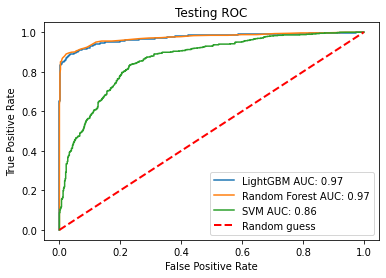

In [597]:
pyplot.plot(ns_fpr, ns_tpr, marker='', linestyle='-',label='LightGBM AUC: '+"{:.2f}".format(auc))
pyplot.plot(ns_fpr_2, ns_tpr_2, marker='', linestyle='-',label='Random Forest AUC: '+"{:.2f}".format(auc_2))
pyplot.plot(ns_fpr_3, ns_tpr_3, marker='', linestyle='-',label='SVM AUC: '+"{:.2f}".format(auc_3))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Testing ROC")
#plt.savefig('test_ROC.png', dpi = 300)

In [510]:
pwd

'/Users/smshovan/ncbi-blast-2.10.0+/pssms/neg_pssms'